In [59]:
%%capture
import networkx as nx
import pandas as pd
import spotipy
from spotipy . oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import random
from spotipy.exceptions import SpotifyException
import scipy

In [60]:
CLIENT_ID = "fe233373eb024c3a97f1eeca78dba3c8"
CLIENT_SECRET = "34f0386560eb4dcb88e317f81b11b961"

auth_manager = SpotifyClientCredentials (client_id = CLIENT_ID, client_secret = CLIENT_SECRET)
sp = spotipy . Spotify ( auth_manager = auth_manager )

## Define the problem

The goal is to discover the most influential artists within different music genres, for a range of genres defined by Spotify. The influential artists would be those who have high popularity and follower counts, and a large number of related artists.


## Data Acquisition

In [61]:
genre_list = sp.recommendation_genre_seeds()
        

In [74]:
counter = 0

G = nx.DiGraph()

for i in genre_list.values():
    for j in i:
        counter += 1
        if counter <= 10:
            top_artists = sp.recommendations(limit = 50, seed_genres=[j])['tracks']
            artists = [track['artists'][0] for track in top_artists]
        else:
            break
        
        for artist in artists:
            artist_data = sp.artist(artist['id'])
            followers = artist_data['followers']['total']
            popularity = artist_data['popularity']
            genres = artist_data['genres']  # Get the genres of the artist
            related_artists = sp.artist_related_artists(artist['id'])['artists']

            # Add a node for the artist into the graph and store its attributes
            G.add_node(artist['id'], name=artist_data['name'], followers=followers, popularity=popularity, genres=genres)

            # For each related artist, add an edge from the artist to the related artist
            for related_artist in related_artists:
                G.add_edge(artist['id'], related_artist['id'])


In [75]:
# Convert the genres list to a string for each artist
for node, data in G.nodes(data=True):
    if 'genres' in data:
        data['genres'] = ', '.join(data['genres'])
        
# Then you can write the graph to a GraphML file
nx.write_graphml(G, "artists_graph.graphml")

In [76]:
# Create an empty DataFrame
import pandas as pd
import networkx as nx

df = pd.DataFrame(columns=['id', 'name', 'followers', 'popularity', 'genres'])

# Add each artist to the DataFrame
for node, data in G.nodes(data=True):
    if not data:  # if data dictionary is empty, skip this iteration
        continue
    new_row = pd.DataFrame([[node, data['name'], data['followers'], data['popularity'], data['genres']]], columns=['id', 'name', 'followers', 'popularity', 'genres'])
    df = pd.concat([df, new_row], ignore_index=True)

# Write the data to a CSV file
df.to_csv('artists_data.csv', index=False)



## Data Preprocessing

In [77]:
print(df.isnull().sum()) #check for missing values

id            0
name          0
followers     0
popularity    0
genres        0
dtype: int64


In [78]:
df = df.dropna() #drop missing values

In [79]:
# Split the genres string back into a list
df['genres'] = df['genres'].apply(lambda x: x.split(', '))

# Explode the DataFrame on the 'genres' column
df = df.explode('genres')

# Write the data to a new CSV file
df.to_csv('artists_genres_data.csv', index=False)


In [89]:
# Suppose G is your graph of artists

# Create an empty genre graph
G_genre = nx.Graph()

# Iterate over artists in the graph
for node, data in G.nodes(data=True):
    # Check if the artist has genres
    if 'genres' in data:
        # Split the genres string into a list of individual genres
        genres = data['genres'].split(', ')
        # For each genre in the list
        for genre in genres:
            # Add the genre as a node in the genre graph
            if not G_genre.has_node(genre):
                G_genre.add_node(genre)
            # Iterate over the rest of the genres in the list
            for other_genre in genres:
                # Do not create an edge with itself
                if genre != other_genre:
                    # Add an edge between the two genres
                    if G_genre.has_edge(genre, other_genre):
                        # increment edge weight if edge already exists
                        G_genre[genre][other_genre]['weight'] += 1
                    else:
                        # create new edge with weight 1
                        G_genre.add_edge(genre, other_genre, weight=1)

# Then you can write the graph to a GraphML file
nx.write_graphml(G, "genre_graph.graphml")

## Data Analysis

In [81]:
df.head(5)

,id,name,followers,popularity,genres
0,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,72311507,89,canadian pop
0,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,72311507,89,pop
1,72T7KgrFiMTgXRWxfuDn5o,Erato,17213,47,acoustic cover
1,72T7KgrFiMTgXRWxfuDn5o,Erato,17213,47,pop folk
2,3FUY2gzHeIiaesXtOAdB7A,Train,4293620,72,dance pop


In [90]:
top_genres = df['genres'].value_counts().head(10)
print(top_genres)


genres
rock                 36
alternative rock     29
                     23
black metal          23
modern rock          23
afropop              23
alternative metal    19
bossa nova           19
blues                17
pop                  17
Name: count, dtype: int64


In [91]:
top_artists_by_genre = {}

for genre in top_genres.index:
    top_artists = df[df['genres'] == genre].sort_values(by=['popularity', 'followers'], ascending=False).head(10)
    top_artists_by_genre[genre] = top_artists['name'].values

print(top_artists_by_genre)


{'rock': array(['Imagine Dragons', 'Daft Punk', 'Nirvana', 'Fleetwood Mac',
       'Radiohead', 'Green Day', 'Foo Fighters', 'Fall Out Boy',
       'System Of A Down', 'Paramore'], dtype=object), 'alternative rock': array(['Radiohead', 'Foo Fighters', 'Pearl Jam', 'MGMT',
       'The Smashing Pumpkins', 'Alice In Chains', 'The Black Keys',
       'Pixies', 'Incubus', 'Stone Temple Pilots'], dtype=object), '': array(["Pickin' On Series", 'Gerald Toto', 'Self', 'The Whites',
       'Martin Stig Andersen', 'Divine Fits', 'The Wrens',
       'VOICE by イヤミ(cv.鈴村健一)', 'Ceorie', 'smileY inc.'], dtype=object), 'black metal': array(['Dimmu Borgir', 'Mayhem', 'Immortal', 'Burzum', 'Bathory',
       'Darkthrone', 'Satyricon', 'Emperor', 'Dark Funeral', 'Marduk'],
      dtype=object), 'modern rock': array(['Imagine Dragons', 'Green Day', 'Foo Fighters', 'Fall Out Boy',
       'Paramore', 'blink-182', 'Florence + The Machine', 'Muse',
       'Kings of Leon', 'Bon Iver'], dtype=object), 'afropop': a

In [92]:
# Calculate the degree centrality for each artist
centrality = nx.degree_centrality(G)

# Sort artists by centrality
sorted_artists = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 artists by degree centrality
print("Top 10 artists by degree centrality:")
for i in range(20):
    artist_id, centrality = sorted_artists[i]
    artist_name = G.nodes[artist_id]['name']
    print(f"{i+1}. {artist_name} ({centrality})")


Top 10 artists by degree centrality:
1. Taake (0.009584664536741215)
2. Emperor (0.00931842385516507)
3. Carpathian Forest (0.009052183173588925)
4. Immortal (0.009052183173588925)
5. Satyricon (0.009052183173588925)
6. Temple Of The Dog (0.008785942492012781)
7. Marduk (0.008785942492012781)
8. Gorgoroth (0.008785942492012781)
9. Rosa Passos (0.008785942492012781)
10. Stone Temple Pilots (0.008519701810436636)
11. Mad Season (0.008519701810436636)
12. Cheikh Lô (0.008519701810436636)
13. Rokia Traoré (0.008519701810436636)
14. Ali Farka Touré (0.008519701810436636)
15. Miúcha (0.008519701810436636)
16. Bush (0.00825346112886049)
17. Built To Spill (0.00825346112886049)
18. The Infamous Stringdusters (0.00825346112886049)
19. Screaming Trees (0.007987220447284346)
20. Habib Koité (0.007987220447284346)


In [96]:
# Calculate the degree for each genre
genre_degrees = G_genre.degree()

# Sort genres by degree
sorted_genres = sorted(genre_degrees, key=lambda x: x[1], reverse=True)

# Print the top 10 genres by degree
print("Top 10 genres by degree:")
for i in range(10):
    genre, degree = sorted_genres[i]
    print(f"{i+1}. {genre} ({degree})")
    
print("------------------------------------------------")
#Reverse sort genres by degree
sorted_genres = sorted(genre_degrees, key=lambda x: x[1], reverse=False)

print("Last 10 genres by degree:")
for i in range(10):
    genre, degree = sorted_genres[i]
    print(f"{i+1}. {genre} ({degree})")

Top 10 genres by degree:
1. rock (61)
2. alternative rock (61)
3. black metal (52)
4. modern rock (47)
5. indie rock (41)
6. singer-songwriter (40)
7. blues rock (39)
8. pagan black metal (37)
9. indietronica (34)
10. intelligent dance music (34)
------------------------------------------------
Last 10 genres by degree:
1. swedish alternative rock (0)
2.  (0)
3. kikuyu pop (0)
4. alternative pop (0)
5. bergen indie (0)
6. anime cv (0)
7. yaoi (0)
8. sambass (0)
9. italian jazz fusion (0)
10. canadian pop (1)


## Visualization

Let's start with analyzing the genres and their connections between eachother.

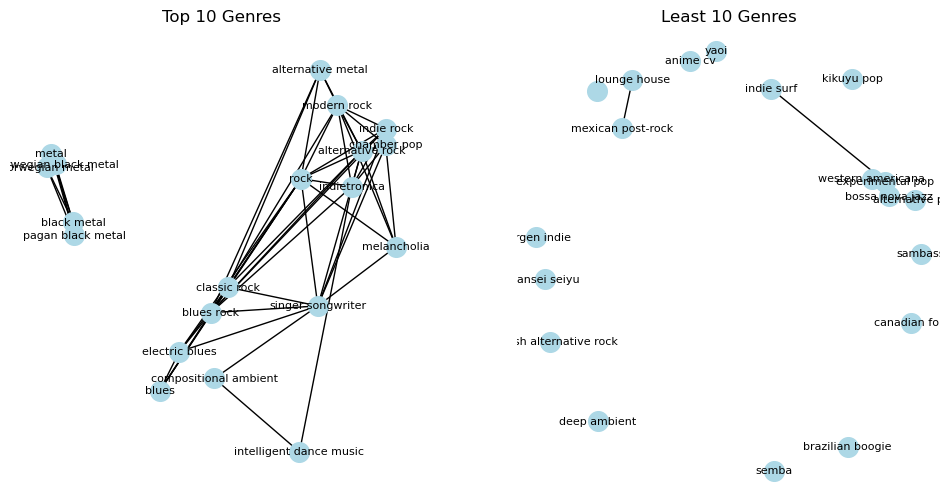

In [116]:
import networkx as nx
import matplotlib.pyplot as plt

# Set the positions of the nodes using a spring layout with increased spacing
pos = nx.spring_layout(G_genre, k=0.5)

# Calculate the edge weights for better visualization
edge_weights = [G_genre[u][v]['weight'] for u, v in G_genre.edges()]

# Sort the genres by degree
sorted_genres = sorted(G_genre.degree(), key=lambda x: x[1], reverse=True)

# Select the top 10 genres and the least 10 genres
top_genres = [genre for genre, _ in sorted_genres[:20]]
least_genres = [genre for genre, _ in sorted_genres[-20:-1]]

# Create separate subgraphs for the top and least genres
top_graph = G_genre.subgraph(top_genres)
least_graph = G_genre.subgraph(least_genres)

# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the top genres
axs[0].set_title('Top 10 Genres')
nx.draw_networkx(top_graph, pos, with_labels=True, node_size=200, node_color='lightblue', font_size=8, font_color='black', ax=axs[0])
axs[0].axis('off')

# Plot the least genres
axs[1].set_title('Least 10 Genres')
nx.draw_networkx(least_graph, pos, with_labels=True, node_size=200, node_color='lightblue', font_size=8, font_color='black', ax=axs[1])
axs[1].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Display the plot
plt.show()


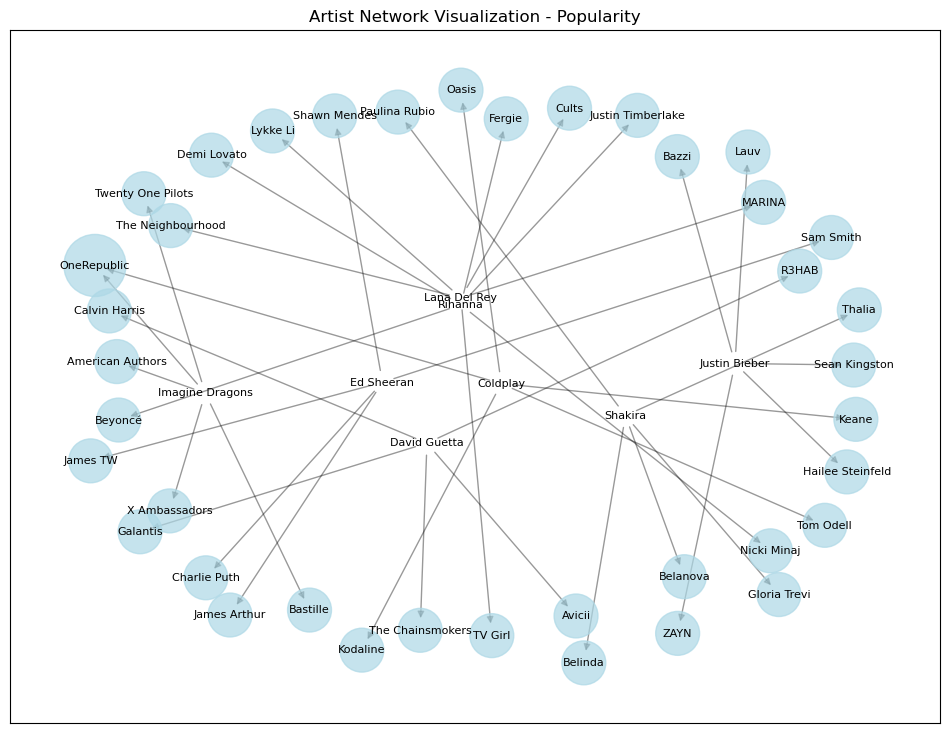

In [145]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Read the data from the CSV file
df = pd.read_csv('artists_data.csv')

# Sort the DataFrame based on popularity in descending order
df = df.sort_values(by='popularity', ascending=False)

# Create an empty directed graph
G = nx.DiGraph()

# Add each artist to the graph until the top 100 artists
for _, row in df.head(8).iterrows():
    artist_id = row['id']
    name = row['name']
    followers = row['followers']
    popularity = row['popularity']
    genres = row['genres']
    
    # Skip nodes with missing values
    if pd.isnull(name):
        continue

    # Add the artist as a node in the graph
    G.add_node(artist_id, name=name, followers=followers, popularity=popularity, genres=genres)

    # Get the related artists for the current artist
    related_artists = sp.artist_related_artists(artist_id)['artists']
    
    # Add the related artists as nodes and edges
    for related_artist in related_artists[:5]:
        related_artist_id = related_artist['id']
        related_artist_name = related_artist['name']
        G.add_node(related_artist_id, name=related_artist_name)
        G.add_edge(artist_id, related_artist_id)

# Set the positions of the nodes using a spring layout
pos = nx.spring_layout(G, k=0.15)

# Calculate the node sizes based on the in-degree (number of incoming edges)
node_sizes = [G.in_degree(artist_id) * 1000 for artist_id in G.nodes()]

# Set the figure size
plt.figure(figsize=(12, 9))

# Draw the nodes and edges of the graph
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.4)

# Add labels to the nodes
node_labels = {node: data['name'] for node, data in G.nodes(data=True) if 'name' in data}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black')

# Set the plot title
plt.title('Artist Network Visualization - Popularity')

# Remove the axis ticks
plt.xticks([])
plt.yticks([])

# Display the plot
plt.show()


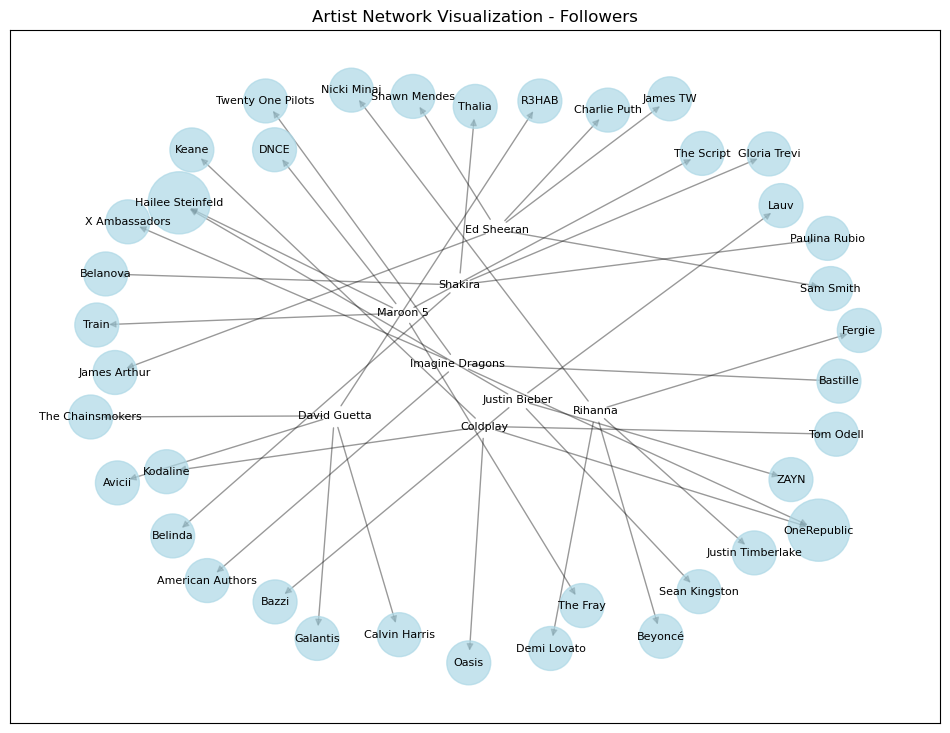

In [148]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Read the data from the CSV file
df = pd.read_csv('artists_data.csv')

# Sort the DataFrame based on popularity in descending order
df = df.sort_values(by='followers', ascending=False)

# Create an empty directed graph
G = nx.DiGraph()

# Add each artist to the graph until the top 100 artists
for _, row in df.head(8).iterrows():
    artist_id = row['id']
    name = row['name']
    followers = row['followers']
    popularity = row['popularity']
    genres = row['genres']
    
    # Skip nodes with missing values
    if pd.isnull(name):
        continue

    # Add the artist as a node in the graph
    G.add_node(artist_id, name=name, followers=followers, popularity=popularity, genres=genres)

    # Get the related artists for the current artist
    related_artists = sp.artist_related_artists(artist_id)['artists']
    
    # Add the related artists as nodes and edges
    for related_artist in related_artists[:5]:
        related_artist_id = related_artist['id']
        related_artist_name = related_artist['name']
        G.add_node(related_artist_id, name=related_artist_name)
        G.add_edge(artist_id, related_artist_id)

# Set the positions of the nodes using a spring layout
pos = nx.spring_layout(G, k=0.15)

# Calculate the node sizes based on the in-degree (number of incoming edges)
node_sizes = [G.in_degree(artist_id) * 1000 for artist_id in G.nodes()]

# Set the figure size
plt.figure(figsize=(12, 9))

# Draw the nodes and edges of the graph
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.4)

# Add labels to the nodes
node_labels = {node: data['name'] for node, data in G.nodes(data=True) if 'name' in data}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black')

# Set the plot title
plt.title('Artist Network Visualization - Followers')

# Remove the axis ticks
plt.xticks([])
plt.yticks([])

# Display the plot
plt.show()


## Discussion of results